### Target Encoding using Traffic Jam: Predicting People's Movement into Nairobi data
When you’re doing supervised learning you often have to deal with categorical variables. That is, variables which don’t have a natural numerical representation. The problem is that most machine learning algorithms require the input data to be numerical. At some point or another a data science pipeline will require converting categorical variables to numerical variables.  
There many way to do so :  
* Label Encoding where you represent each category with random number.   
* One-hot encoding where you create one binary column per category  
* Target encoding where you where you calculate some statistical measure like (mean,max,min ...) of target value by category     

In this notebook we will focuse in the diffrece way to apply Target encoding.  
#### Import our require library

In [ ]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

#### Load the data 

### Data understanding

In [64]:
train=pd.read_csv("./Data/train.zip")
test=pd.read_csv("./Data/test.csv")

#### The first step to solve of this problem is to create the train set. Since the data provides information about ticket transactions, we need to group it by ride_id to to find the right number of tickets per ride.


In [65]:
Target=train.groupby(["ride_id"]).seat_number.count().rename("number_of_ticket").reset_index()
train=train.drop_duplicates("ride_id").drop(['payment_method', 'payment_receipt', 'seat_number'],axis=1)
train=train.merge(Target,how="left",on="ride_id")

train.drop(["travel_to"],axis=1,inplace=True)
test.drop(["travel_to"],axis=1,inplace=True)

In [66]:
train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket
0,1442,17-10-17,7:15,Migori,Bus,49,1
1,5437,19-11-17,7:12,Migori,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5
4,5778,27-11-17,7:12,Migori,Bus,49,31


In [67]:
test.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Bus,49
1,256,2018-05-06,11:08,Kisii,shuttle,11
2,275,2018-05-04,05:00,Kisii,shuttle,11
3,285,2018-05-04,09:10,Kisii,shuttle,11
4,286,2018-05-04,09:20,Kisii,shuttle,11


### Data preparation part 1 

#### proccing the date columns and add Time features

In [68]:
def add_20(x):
    """
    add 20 sting to the date 
    args:
        string date in this format 18/02/01
    return:
        string date with adding 20  like 2018/02/01
    """
    date=x.split("-")
    date[-1]="20"+date[-1]
    return "-".join(date)
train["date"]=(train["travel_date"].apply(add_20)+" "+train["travel_time"]).astype(str)
test["date"]=(test["travel_date"]+" "+test["travel_time"]).astype(str)

In [69]:
def  time_features(x): 
    """
    create date features 
    args:
        date in string format 
    return : 
        date data frame with the added features 
    """
    x["date"]=pd.to_datetime(x["date"],format='%d-%m-%Y %H:%M')
    x["dayofweek"]=x["date"].dt.dayofweek
    x["dayofyear"]=x["date"].dt.dayofyear
    x["dayofmonth"]=x["date"].dt.day
    x["year_woy"]=x["date"].dt.year.astype(str)+x["date"].dt.weekofyear.astype(str)
    x["hour"]=x["date"].dt.hour
    x["minute"]=x["date"].dt.minute
    x["is_weekend"]=x["dayofweek"].apply( lambda x : 1 if x  in [5,6] else 0 )
    x["year"]=x["date"].dt.year
    x["quarter"]=x["date"].dt.quarter
    x["month"]=x["date"].dt.month
    

    return x 
train=time_features(train)

In [70]:
def  time_features(x): 
        """
    create date features 
    args:
        date in string format 
    return : 
        date data frame with the added features 
    """
    x["date"]=pd.to_datetime(x["date"],format='%Y-%m-%d %H:%M')
    x["dayofweek"]=x["date"].dt.dayofweek
    x["hour"]=x["date"].dt.hour
    x["minute"]=x["date"].dt.minute
    x["dayofyear"]=x["date"].dt.dayofyear
    x["dayofmonth"]=x["date"].dt.day
    x["is_weekend"]=x["dayofweek"].apply( lambda x : 1 if x  in [5,6] else 0 )
    x["year_woy"]=x["date"].dt.year.astype(str)+x["date"].dt.weekofyear.astype(str)
    x["year"]=x["date"].dt.year
    x["quarter"]=x["date"].dt.quarter
    x["month"]=x["date"].dt.month
    return x 
test=time_features(test)

In [71]:
test.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,date,dayofweek,hour,minute,dayofyear,dayofmonth,is_weekend,year_woy,year,quarter,month
0,247,2018-05-07,07:06,Kisii,Bus,49,2018-05-07 07:06:00,0,7,6,127,7,0,201819,2018,2,5
1,256,2018-05-06,11:08,Kisii,shuttle,11,2018-05-06 11:08:00,6,11,8,126,6,1,201818,2018,2,5
2,275,2018-05-04,05:00,Kisii,shuttle,11,2018-05-04 05:00:00,4,5,0,124,4,0,201818,2018,2,5
3,285,2018-05-04,09:10,Kisii,shuttle,11,2018-05-04 09:10:00,4,9,10,124,4,0,201818,2018,2,5
4,286,2018-05-04,09:20,Kisii,shuttle,11,2018-05-04 09:20:00,4,9,20,124,4,0,201818,2018,2,5


In [72]:
train.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,dayofmonth,year_woy,hour,minute,is_weekend,year,quarter,month
0,1442,17-10-17,7:15,Migori,Bus,49,1,2017-10-17 07:15:00,1,290,17,201742,7,15,0,2017,4,10
1,5437,19-11-17,7:12,Migori,Bus,49,1,2017-11-19 07:12:00,6,323,19,201746,7,12,1,2017,4,11
2,5710,26-11-17,7:05,Keroka,Bus,49,1,2017-11-26 07:05:00,6,330,26,201747,7,5,1,2017,4,11
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5,2017-11-27 07:10:00,0,331,27,201748,7,10,0,2017,4,11
4,5778,27-11-17,7:12,Migori,Bus,49,31,2017-11-27 07:12:00,0,331,27,201748,7,12,0,2017,4,11


#### Select the categorical feautres

In [73]:
categorical_feautres=["travel_from","car_type","dayofweek","dayofmonth","hour","minute","year"]

### Business understanding

In order to make sense of the data, we visualize some chart to answer this follwoing questions:  
1) what is the average of bus tickets sales in each starting point.   
2) what is the avrage bus tickets sales per type of bus.  
3) what is the avrage bus tickets sales in each day of week    
4) what is the avrage ticket sales per day of month.  
5) what is the avrage ticket sales in each hour.  

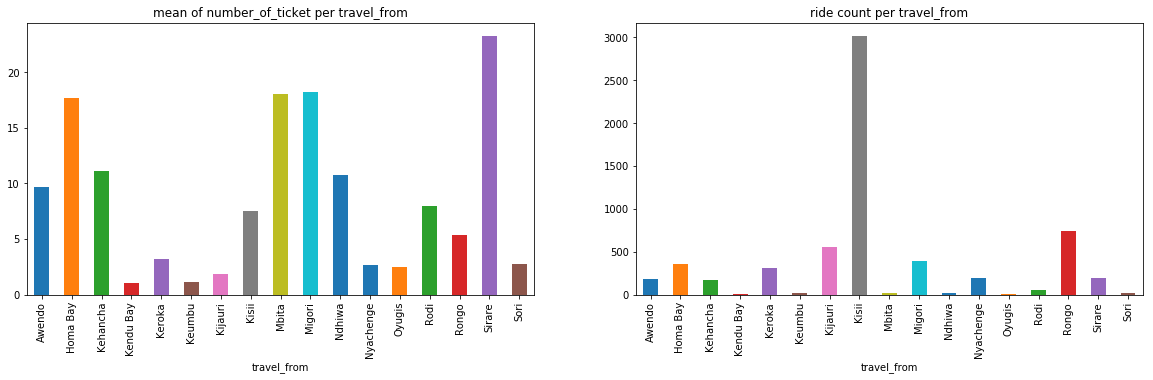

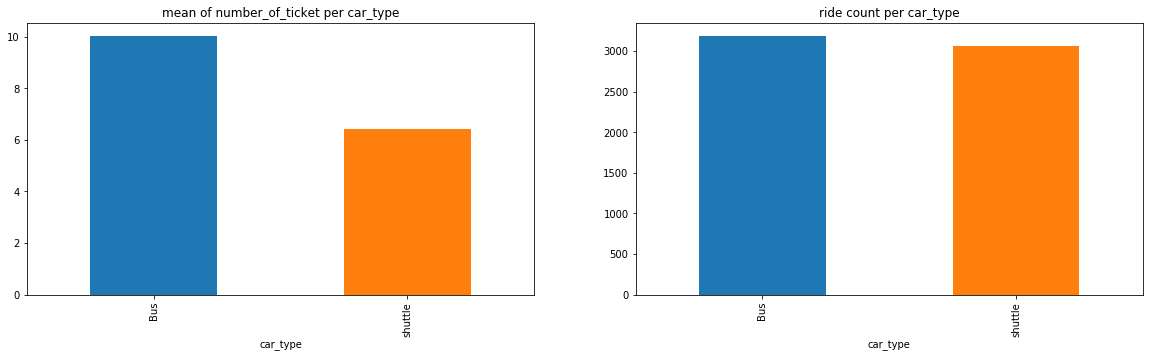

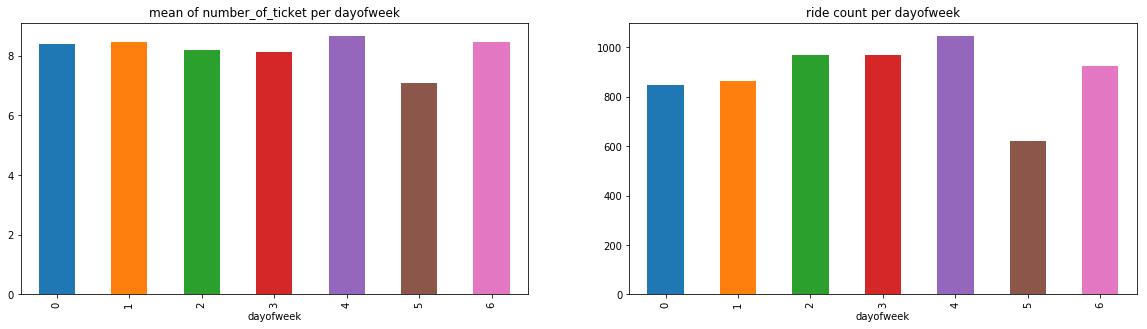

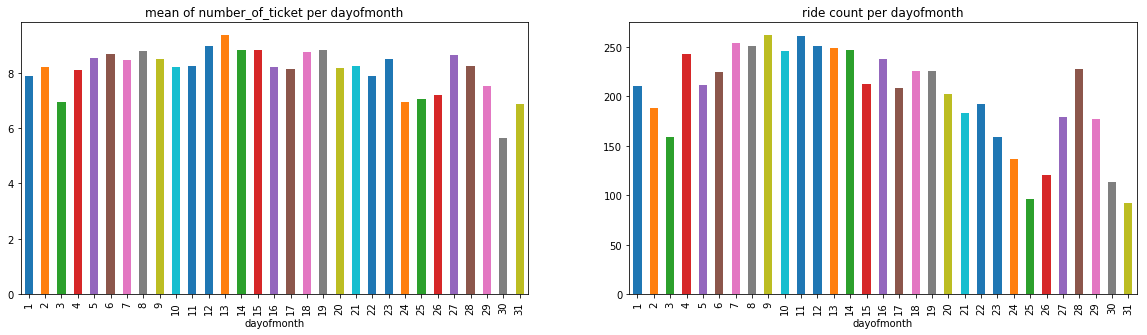

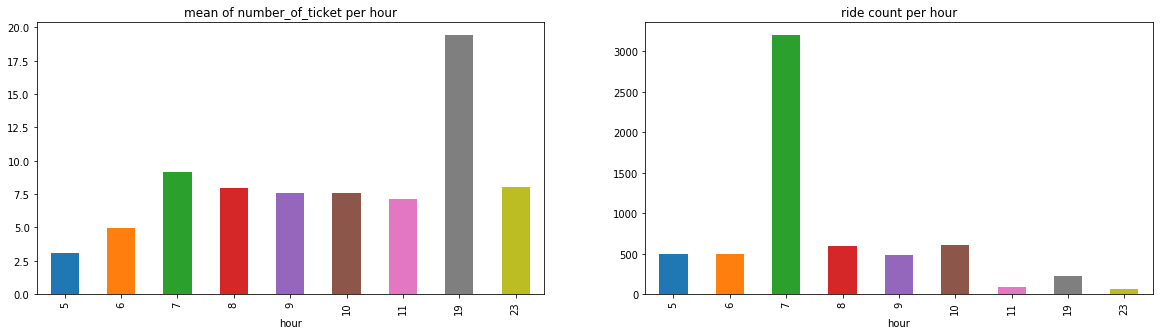

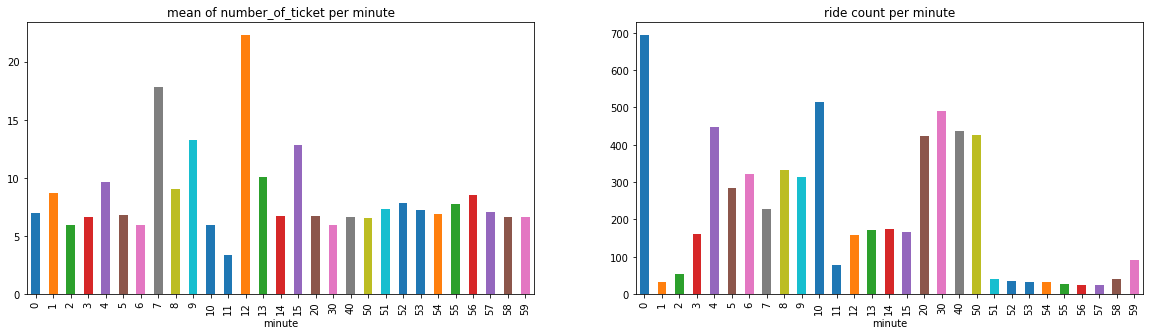

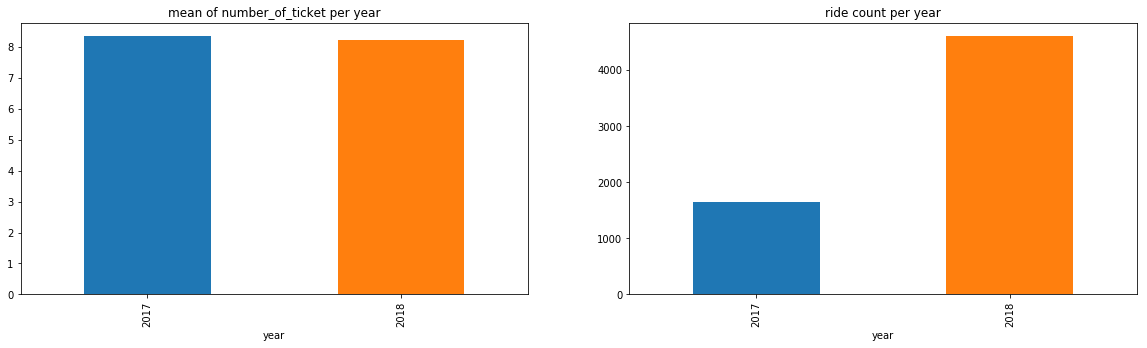

In [74]:
def plot_categorical_feature(feautre):
    """
    plot categorical features 
    
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    train.groupby(feautre).number_of_ticket.mean().plot(kind="bar",ax=axes[0],figsize=(20,5),title="mean of number_of_ticket per {}".format(feautre))
    train.groupby(feautre).number_of_ticket.count().plot(kind="bar",ax=axes[1],figsize=(20,5),title="ride count per {}".format(feautre))    
    plt.show()
for feautre in categorical_feautres : 
    plot_categorical_feature(feautre)

#####  let's define funcation which take as inpute data frame, name of the catgorical feautre , the name of the target column , stastical funcations and return an aggregate data frame grouped by the catgorical feautre  

### Data preparation part 2 

In [235]:
def target_encoding(data,feautre,target="number_of_ticket",agg_functions={"mean","std"}):
    """ 
    create target encoding features 
    args : 
        data : data frame 
        features : column to be aggregated 
        target : the target column name 
        agg_funcations : dict of aggregation functions  
    return 
        agg : aggregated data frame 
    """
    agg=data.groupby(feautre)[target].agg(agg_functions)
    agg.columns=[column+"_per_{}_{}".format(feautre,target) for column in  agg.columns.tolist()]
    return agg    

In [236]:
target_encoding(train,"dayofweek","number_of_ticket",{"mean","min","max","median"})

,max_per_dayofweek_number_of_ticket,min_per_dayofweek_number_of_ticket,median_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket
dayofweek,,,,
0,49,1,6,8.409198
1,50,1,7,8.475145
2,49,1,7,8.192585
3,48,1,7,8.137113
4,47,1,8,8.675573
5,48,1,3,7.101124
6,47,1,7,8.462121


In [237]:
train_TE=train.copy()
test_TE=test.copy()

##### we define another helper function to calculte the aggregate data frame for each catgeroical feautres and join with the train , test set 

In [238]:
def add_target_encoding_features(train,test):
    """
    genrate aggregate features 
    args: 
        train : data frame  
        test : data frame
    return  : 
        train : data frame  
        test : data fame 
    """
    for feautre in categorical_feautres : 
        agg=target_encoding(train,feautre)
        train=train.merge(agg,how="left",on=feautre)
        test=test.merge(agg,how="left",on=feautre)
    return train,test
train_TE,test_TE=add_target_encoding_features(train_TE,test_TE)   

In many cases when  you use the whole train set to calculate the aggregate features you will end up with a good score in the training and validation  set and a bad score in the test set(overfitting),due to strong correlation  between the new generated  features and the target in the train set. To avoid this problem  we should split our  train data to new train and validation    from beginning and calculate the aggregate features using only the new train and join it later with the the validation set the test set,after that we compare the score of the traing and the validation to know if the  aggregate feautres are overfitting or not   

In [239]:
train_VTE,val_VTE=train_test_split(train,random_state=1994,test_size=0.1)
test_VTE=test.copy()

In [240]:
def add_target_encoding_features_validation(train,val,test):
    """
    genrate aggregate features using the train only and merge the result with the train , val and the test data frames
    args: 
        train : data frame  
        test : data frame
        val : data frame 
    return  : 
        train : data frame  
        test : data fame 
        val : data frame 
    """
    for feautre in categorical_feautres : 
        agg=target_encoding(train,feautre)
        train=train.merge(agg,how="left",on=feautre)
        val=val.merge(agg,how="left",on=feautre)
        test=test.merge(agg,how="left",on=feautre)
        
    return train,val,test

In [241]:
train_VTE,val_VTE,test_VTE=add_target_encoding_features_validation(train_VTE,val_VTE,test_VTE)

In [242]:
train_VTE.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,...,std_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofmonth_number_of_ticket,mean_per_dayofmonth_number_of_ticket,std_per_hour_number_of_ticket,mean_per_hour_number_of_ticket,std_per_minute_number_of_ticket,mean_per_minute_number_of_ticket,std_per_year_number_of_ticket,mean_per_year_number_of_ticket
0,11338,14-12-17,8:50,Kisii,shuttle,11,11,2017-12-14 08:50:00,3,348,...,8.179312,8.160000,8.491308,8.873362,4.768677,7.965844,3.912548,6.618321,7.836962,8.318367
1,10431,28-12-17,10:58,Kisii,shuttle,11,1,2017-12-28 10:58:00,3,362,...,8.179312,8.160000,7.427756,8.105263,3.768129,7.502762,4.354656,6.485714,7.836962,8.318367
2,8709,16-01-18,7:04,Homa Bay,Bus,49,31,2018-01-16 07:04:00,1,16,...,8.355861,8.355007,9.546244,8.502304,9.775881,9.195509,9.631956,9.709360,8.866694,8.265286
3,11961,06-12-17,9:10,Kisii,shuttle,11,11,2017-12-06 09:10:00,2,340,...,8.732400,8.234357,8.536107,8.736318,3.645320,7.575342,4.394825,6.015590,7.836962,8.318367
4,7954,21-12-17,7:11,Homa Bay,Bus,49,2,2017-12-21 07:11:00,3,355,...,8.179312,8.160000,8.840447,8.278788,9.775881,9.195509,4.414732,3.400000,7.836962,8.318367


In [243]:
val_VTE.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,...,std_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofmonth_number_of_ticket,mean_per_dayofmonth_number_of_ticket,std_per_hour_number_of_ticket,mean_per_hour_number_of_ticket,std_per_minute_number_of_ticket,mean_per_minute_number_of_ticket,std_per_year_number_of_ticket,mean_per_year_number_of_ticket
0,5897,12-04-18,5:20,Kisii,shuttle,11,11,2018-04-12 05:20:00,3,102,...,8.179312,8.160000,8.518181,8.807860,3.483794,3.058691,4.012592,6.573333,8.866694,8.265286
1,12649,29-11-17,6:20,Kisii,shuttle,11,2,2017-11-29 06:20:00,2,333,...,8.732400,8.234357,7.624334,7.881250,4.067445,4.840909,4.012592,6.573333,7.836962,8.318367
2,11774,06-03-18,7:06,Keroka,Bus,49,1,2018-03-06 07:06:00,1,65,...,8.355861,8.355007,8.536107,8.736318,9.775881,9.195509,7.884698,6.085911,8.866694,8.265286
3,11064,22-02-18,5:50,Kijauri,shuttle,11,2,2018-02-22 05:50:00,3,53,...,8.179312,8.160000,6.987652,7.639053,3.483794,3.058691,3.912548,6.618321,8.866694,8.265286
4,12316,16-03-18,7:10,Homa Bay,Bus,49,1,2018-03-16 07:10:00,4,75,...,8.387088,8.779082,9.546244,8.502304,9.775881,9.195509,4.394825,6.015590,8.866694,8.265286


In [244]:
test_VTE.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,date,dayofweek,hour,minute,...,std_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofmonth_number_of_ticket,mean_per_dayofmonth_number_of_ticket,std_per_hour_number_of_ticket,mean_per_hour_number_of_ticket,std_per_minute_number_of_ticket,mean_per_minute_number_of_ticket,std_per_year_number_of_ticket,mean_per_year_number_of_ticket
0,247,2018-05-07,07:06,Kisii,Bus,49,2018-05-07 07:06:00,0,7,6,...,8.935214,8.342484,8.926552,8.537445,9.775881,9.195509,7.884698,6.085911,8.866694,8.265286
1,256,2018-05-06,11:08,Kisii,shuttle,11,2018-05-06 11:08:00,6,11,8,...,8.550053,8.516206,8.536107,8.736318,3.837963,7.253165,8.078795,9.019737,8.866694,8.265286
2,275,2018-05-04,05:00,Kisii,shuttle,11,2018-05-04 05:00:00,4,5,0,...,8.387088,8.779082,8.619692,8.004444,3.483794,3.058691,7.554865,6.883387,8.866694,8.265286
3,285,2018-05-04,09:10,Kisii,shuttle,11,2018-05-04 09:10:00,4,9,10,...,8.387088,8.779082,8.619692,8.004444,3.645320,7.575342,4.394825,6.015590,8.866694,8.265286
4,286,2018-05-04,09:20,Kisii,shuttle,11,2018-05-04 09:20:00,4,9,20,...,8.387088,8.779082,8.619692,8.004444,3.645320,7.575342,4.012592,6.573333,8.866694,8.265286


also there is another way to do so by using K fold split 

In [245]:
def add_target_encoding_features_Kfold(train,test,split=10):
    """
    create aggregated features using K fold  mehod
    args : 
        train : data frame 
        test  : data frame  
        split : number of K fold split  
    return : 
        train : data frame  
        test  : data frame 
    """
    kf = KFold(n_splits=split,random_state=2222,shuffle=False)
    train_final=[]
    for train_index, test_index in kf.split(train):
        train_fold, val_fold = train.loc[train_index], train.loc[test_index]
        for  feautres in categorical_feautres:
            agg=target_encoding(train_fold,feautres)
            val_fold=val_fold.merge(agg,how="left",on=feautres)
        train_final.append(val_fold)
    
    for  feautres in categorical_feautres : 
        agg=target_encoding(train,feautres)
        test=test.merge(agg,how="left",on=feautres)
        
        
    return pd.concat(train_final),test

In [246]:
train_KTE=train.copy()
test_KTE=test.copy()

In [247]:
train_KTE,test_KTE=add_target_encoding_features_Kfold(train=train_KTE,test=test_KTE)

In [248]:
test_KTE.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,date,dayofweek,hour,minute,...,std_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofmonth_number_of_ticket,mean_per_dayofmonth_number_of_ticket,std_per_hour_number_of_ticket,mean_per_hour_number_of_ticket,std_per_minute_number_of_ticket,mean_per_minute_number_of_ticket,std_per_year_number_of_ticket,mean_per_year_number_of_ticket
0,247,2018-05-07,07:06,Kisii,Bus,49,2018-05-07 07:06:00,0,7,6,...,8.991864,8.409198,8.671242,8.464567,9.739081,9.123711,7.734458,5.943925,8.893375,8.229234
1,256,2018-05-06,11:08,Kisii,shuttle,11,2018-05-06 11:08:00,6,11,8,...,8.599534,8.462121,8.648121,8.680000,3.799647,7.126437,8.158904,9.057229,8.893375,8.229234
2,275,2018-05-04,05:00,Kisii,shuttle,11,2018-05-04 05:00:00,4,5,0,...,8.407693,8.675573,8.684263,8.115226,3.478625,3.042169,7.504519,6.945166,8.893375,8.229234
3,285,2018-05-04,09:10,Kisii,shuttle,11,2018-05-04 09:10:00,4,9,10,...,8.407693,8.675573,8.684263,8.115226,3.662312,7.565574,4.349472,5.980583,8.893375,8.229234
4,286,2018-05-04,09:20,Kisii,shuttle,11,2018-05-04 09:20:00,4,9,20,...,8.407693,8.675573,8.684263,8.115226,3.662312,7.565574,4.010635,6.716981,8.893375,8.229234


In [249]:
train_KTE.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,...,std_per_dayofweek_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofmonth_number_of_ticket,mean_per_dayofmonth_number_of_ticket,std_per_hour_number_of_ticket,mean_per_hour_number_of_ticket,std_per_minute_number_of_ticket,mean_per_minute_number_of_ticket,std_per_year_number_of_ticket,mean_per_year_number_of_ticket
0,1442,17-10-17,7:15,Migori,Bus,49,1,2017-10-17 07:15:00,1,290,...,8.886729,8.912304,9.062090,8.690722,9.892324,9.381113,10.962305,13.103896,7.908393,8.550272
1,5437,19-11-17,7:12,Migori,Bus,49,1,2017-11-19 07:12:00,6,323,...,8.826517,8.768957,9.072665,9.293839,9.892324,9.381113,14.532541,23.198630,7.908393,8.550272
2,5710,26-11-17,7:05,Keroka,Bus,49,1,2017-11-26 07:05:00,6,330,...,8.826517,8.768957,9.079240,7.693694,9.892324,9.381113,5.885704,6.936803,7.908393,8.550272
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5,2017-11-27 07:10:00,0,331,...,9.153959,8.797120,10.705519,9.043750,9.892324,9.381113,4.382422,6.070796,7.908393,8.550272
4,5778,27-11-17,7:12,Migori,Bus,49,31,2017-11-27 07:12:00,0,331,...,9.153959,8.797120,10.705519,9.043750,9.892324,9.381113,14.532541,23.198630,7.908393,8.550272


### Traing part 

Defin functoin to train our data in one fold wich take train,validation,test data and return the predection of the train,validation and test

In [250]:
def train_model(X_train,Y_train,X_val,Y_val,X_test,parmaters,features_name): 
    """
        train model funcation 
        args  :
            X_train,Y_train,X_val,Y_val,X_test : data frames 
            parmaters : model parmaters
            features_name : features for the train 
        return : 
        train_pred :  Data frame 
        vaild_pred :  Data frame 
        test_pred  : Data frame 
    """
    d_train = xgb.DMatrix(X_train, Y_train,feature_names=features_name)
    d_valid = xgb.DMatrix(X_val, Y_val,feature_names=features_name)
    d_test = xgb.DMatrix(X_test,feature_names=features_name)
    list_track = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(parmaters, d_train, 2000,  list_track, maximize=False, verbose_eval=50, early_stopping_rounds=50)
    train_pred =model.predict(d_train)              
    valid_pred =model.predict(d_valid)   
    test_pred = model.predict(d_test)
    return train_pred ,valid_pred,test_pred
  

Defin K fold function which use trian_model function with k fold and return the predction of the train for each  fold and the test set

In [251]:
def train_kfold(X_train,Y_train,X_test,parmaters,features_name,split=5,):
    """
    train the data using K fold method 
    """
    final_train_pred=np.zeros_like(Y_train)
    final_test_pred=np.zeros(len(X_test))
    
    kf = KFold(n_splits=split,random_state=2222)
    i=1
    for train_index, val_index in kf.split(X_train):
        print("fold:"+str(i))
        train_fold_features, val_fold_features = X_train.loc[train_index], X_train.loc[val_index]
        train_fold_target, val_fold_target = Y_train.loc[train_index], Y_train.loc[val_index] 
        train_pred ,valid_pred,test_pred=train_model( 
                                                        X_train=train_fold_features,
                                                        Y_train= train_fold_target,
                                                        X_val= val_fold_features,
                                                        Y_val= val_fold_target,
                                                        X_test= X_test,
                                                        parmaters=parmaters,
                                                        features_name=features_name 
                                                    )
        
        final_train_pred[val_index]=valid_pred
        final_test_pred=final_test_pred+test_pred/split
        i=i+1
    return final_train_pred,final_train_pred


In [252]:
train.columns

Index(['ride_id', 'travel_date', 'travel_time', 'travel_from', 'car_type',
       'max_capacity', 'number_of_ticket', 'date', 'dayofweek', 'dayofyear',
       'dayofmonth', 'year_woy', 'hour', 'minute', 'is_weekend', 'year',
       'quarter', 'month'],
      dtype='object')

remove unusful columns 

In [253]:
columns_to_remove=['ride_id', 'travel_date', 'travel_time', 'travel_from', 'car_type',
       'max_capacity', 'number_of_ticket', 'date', 'dayofweek', 'dayofyear',
       'dayofmonth', 'year_woy', 'hour', 'minute', 'year',
       'quarter', 'month']
features_name=train_KTE.drop(columns_to_remove,axis=1).columns

### Data Modeling


## Train the model with the first Target encoding apporach 

In [261]:
train_TE_train,train_TE_val=train_test_split(train_TE,random_state=1994,test_size=0.1)

X_train=train_TE_train[features_name]
Y_train=train_TE_train["number_of_ticket"]

X_val=train_TE_val[features_name]
Y_val=train_TE_val["number_of_ticket"]

X_test=test_TE[features_name]

In [256]:
params = {'eta': 0.004, 'colsample_bytree': 0.7, 
               'max_depth': 9,'subsample': 0.9, 'lambda': 4, 'nthread': 8, 'booster' : 'gbtree', 'silent': 1,
               'eval_metric': 'rmse', 'objective': 'reg:linear',"gamma":0.1 ,"alpha":0.01} 
train_pred ,valid_pred,test_pred=train_model(X_train,Y_train,X_val,Y_val,X_test,params,features_name)

[0]	train-rmse:11.5704	valid-rmse:11.6523
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.0544	valid-rmse:10.1954
[100]	train-rmse:8.85509	valid-rmse:9.06086
[150]	train-rmse:7.90693	valid-rmse:8.18352
[200]	train-rmse:7.16422	valid-rmse:7.5106
[250]	train-rmse:6.57704	valid-rmse:6.99349
[300]	train-rmse:6.12004	valid-rmse:6.60618
[350]	train-rmse:5.75626	valid-rmse:6.31382
[400]	train-rmse:5.47005	valid-rmse:6.0987
[450]	train-rmse:5.24	valid-rmse:5.9389
[500]	train-rmse:5.04931	valid-rmse:5.81598
[550]	train-rmse:4.89532	valid-rmse:5.72955
[600]	train-rmse:4.7627	valid-rmse:5.66193
[650]	train-rmse:4.64749	valid-rmse:5.61553
[700]	train-rmse:4.5475	valid-rmse:5.58261
[750]	train-rmse:4.45635	valid-rmse:5.55732
[800]	train-rmse:4.37751	valid-rmse:5.53989
[850]	train-rmse:4.30183	valid-rmse:5.52293
[900]	train-rmse:4.23239	valid-rmse:5.51549
[950]	train-rmse:4.16738	valid

In [257]:
print(mean_absolute_error.__name__,"Train",mean_absolute_error(train_pred,Y_train))
print(mean_absolute_error.__name__,"Validation",mean_absolute_error(Y_val,valid_pred))

mean_absolute_error Train 2.6593059340271976
mean_absolute_error Validation 3.5368973982334135


## Train the model with the second Target encoding apporach 

In [263]:
X_train=train_VTE[features_name]
Y_train=train_VTE["number_of_ticket"]
X_val=val_VTE[features_name]
Y_val=val_VTE["number_of_ticket"]
X_test=test_VTE[features_name]

In [264]:
params = {'eta': 0.004, 'colsample_bytree': 0.7, 
               'max_depth': 9,'subsample': 0.9, 'lambda': 4, 'nthread': 8, 'booster' : 'gbtree', 'silent': 1,
               'eval_metric': 'rmse', 'objective': 'reg:linear',"gamma":0.1 ,"alpha":0.01} 
train_pred ,valid_pred,test_pred=train_model(X_train,Y_train,X_val,Y_val,X_test,params,features_name)

[0]	train-rmse:11.5704	valid-rmse:11.6517
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.0583	valid-rmse:10.2159
[100]	train-rmse:8.86258	valid-rmse:9.10201
[150]	train-rmse:7.91884	valid-rmse:8.24528
[200]	train-rmse:7.18025	valid-rmse:7.58669
[250]	train-rmse:6.5958	valid-rmse:7.08154
[300]	train-rmse:6.14116	valid-rmse:6.70157
[350]	train-rmse:5.78246	valid-rmse:6.41656
[400]	train-rmse:5.49947	valid-rmse:6.20539
[450]	train-rmse:5.27177	valid-rmse:6.04832
[500]	train-rmse:5.08281	valid-rmse:5.92895
[550]	train-rmse:4.93139	valid-rmse:5.84564
[600]	train-rmse:4.7997	valid-rmse:5.78398
[650]	train-rmse:4.68427	valid-rmse:5.73775
[700]	train-rmse:4.58379	valid-rmse:5.70784
[750]	train-rmse:4.49348	valid-rmse:5.68334
[800]	train-rmse:4.41434	valid-rmse:5.66467
[850]	train-rmse:4.33914	valid-rmse:5.65378
[900]	train-rmse:4.27125	valid-rmse:5.64794
[950]	train-rmse:4.20651

In [265]:
print(mean_absolute_error.__name__,"Train",mean_absolute_error(train_pred,Y_train))
print(mean_absolute_error.__name__,"Validation",mean_absolute_error(Y_val,valid_pred))

mean_absolute_error Train 2.6953015041194464
mean_absolute_error Validation 3.5934159786224367


## Train the model with the first Target encoding apporach with kfold

In [267]:
X_train=train_TE[features_name]
Y_train=train_TE["number_of_ticket"]
X_test=test_TE[features_name]

In [268]:
train_pred,test_pred= train_kfold(X_train,Y_train,X_test,params,features_name,split=10)

fold:1
[0]	train-rmse:11.9764	valid-rmse:7.04547
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.3868	valid-rmse:6.05281
[100]	train-rmse:9.12596	valid-rmse:5.39235
[150]	train-rmse:8.12612	valid-rmse:4.99034
[200]	train-rmse:7.34182	valid-rmse:4.78126
[250]	train-rmse:6.71994	valid-rmse:4.69667
[300]	train-rmse:6.23433	valid-rmse:4.69244
Stopping. Best iteration:
[276]	train-rmse:6.45371	valid-rmse:4.68513

fold:2
[0]	train-rmse:11.6743	valid-rmse:10.6828
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.153	valid-rmse:9.35479
[100]	train-rmse:8.94872	valid-rmse:8.31074
[150]	train-rmse:7.99657	valid-rmse:7.48187
[200]	train-rmse:7.25053	valid-rmse:6.83232
[250]	train-rmse:6.65869	valid-rmse:6.3354
[300]	train-rmse:6.19655	valid-rmse:5.96539
[350]	train-rmse:

In [270]:
print(mean_absolute_error.__name__,"CV =",mean_absolute_error(train_pred,Y_train))

mean_absolute_error CV = 3.8751800288046088


## Train the model with the third Target encoding apporach 

In [272]:
train_KTE.reset_index(inplace=True,drop=True)
X_train=train_KTE[features_name]
Y_train=train_KTE["number_of_ticket"]
X_test=test_KTE[features_name]

In [273]:
train_pred,test_pred= train_kfold(X_train,Y_train,X_test,params,features_name,split=10)

fold:1
[0]	train-rmse:11.9762	valid-rmse:7.04534
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.3453	valid-rmse:6.21458
[100]	train-rmse:9.03558	valid-rmse:5.64969
[150]	train-rmse:7.98153	valid-rmse:5.28501
[200]	train-rmse:7.14185	valid-rmse:5.05656
[250]	train-rmse:6.46619	valid-rmse:4.92753
[300]	train-rmse:5.93194	valid-rmse:4.86801
[350]	train-rmse:5.4928	valid-rmse:4.84657
[400]	train-rmse:5.14474	valid-rmse:4.857
Stopping. Best iteration:
[352]	train-rmse:5.47863	valid-rmse:4.84657

fold:2
[0]	train-rmse:11.6739	valid-rmse:10.6839
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:10.1079	valid-rmse:9.48016
[100]	train-rmse:8.85012	valid-rmse:8.47487
[150]	train-rmse:7.83657	valid-rmse:7.71521
[200]	train-rmse:7.02906	valid-rmse:7.11543
[250]	train-rmse:6

### Evaluation 

In [274]:
print(mean_absolute_error.__name__,"CV =",mean_absolute_error(train_pred,Y_train))

mean_absolute_error CV = 3.966874699951992
